## Trend analysis

In [9]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmcrameri.cm as cm

from proteus.config import read_config


In [10]:
import utils.load_grid as lg

In [11]:
pgrid_dir =  "data/output/l9859b_grid2/"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

In [43]:
# Case numbers
cnums = ["%d"%int(s.split("_")[-1]) for s in cases]

In [52]:
# Helpfiles
helps, hvars = lg.load_helpfiles(cases)

# Statuses
statuses = lg.get_statuses(pgrid_dir)

# Configuration variables
conf = []
for f in cases:
    conf.append( read_config(f+"/init_coupler.toml") )

print("Done")

Helpfiles: 100%|██████████| 192/192 [00:01<00:00, 147.95it/s]


Done


In [29]:
%matplotlib inline

## Variable1 vs Variable2 scatter plot

In [60]:
def trend_any(x,x_lbl, y,y_lbl, control,
                xscale='linear', yscale='linear', zscale='linear',
                histogram=True, nbins=10, plt_cnums=False):

    fig,ax = plt.subplots(figsize=(5,4))

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)

    xs = []
    ys = []
    cs = [] # colour
    ns = [] # case number
    for i in range(ncases):
        skip_this = False
        for k in control.keys():
            if not np.isclose(lg.descend_get(conf[i],k),control[k]):
                skip_this = True
                break

        if not skip_this:
            # x var
            if '.' in x:
                xs.append(lg.descend_get(conf[i],x))
            else:
                xs.append(lg.access_hvars(hvars,x,-1)[i])

            # y var
            if '.' in y:
                ys.append(lg.descend_get(conf[i],y))
            else:
                ys.append(lg.access_hvars(hvars,y,-1)[i])

            # case number
            ns.append(cnums[i])

            # colour
            if lg.access_hvars(hvars,"Phi_global",-1)[i] < 0.05:
                color='black'
            else:
                color='orange'
            cs.append(color)

    # mask = np.argsort(xs)
    # xs = np.array(xs)[mask]
    # ys = np.array(ys)[mask]
    # cs = np.array(cs)[mask]
    # ns = np.array(ns)[mask]

    if xscale != 'linear':
        if xscale == "log":
            ax.set_xscale("log")
        else:
            ax.set_xscale("symlog")
        if histogram:
            bins_x = np.logspace(np.log10(np.amin(xs)) , np.log10(np.amax(xs)), nbins)
    else:
        if histogram:
            bins_x = np.linspace(np.amin(xs) , np.amax(xs), nbins)

    if yscale != 'linear':
        if yscale == "log":
            ax.set_yscale("log")
        else:
            ax.set_yscale("symlog")
        if histogram:
            bins_y = np.logspace(np.log10(np.amin(ys)) , np.log10(np.amax(ys)), nbins)
    else:
        if histogram:
            bins_y = np.linspace(np.amin(ys) , np.amax(ys), nbins)

    if histogram:
        hist,xe,ye,img = ax.hist2d(xs,ys, bins=[bins_x, bins_y], norm=zscale, cmap=cm.oslo_r)
        cax = make_axes_locatable(ax).append_axes('top', size='5%', pad=0.05)
        fig.colorbar(img, cax=cax, orientation='horizontal', location='top')
    else:
        for i in range(len(xs)):

            stat = statuses[int(cnums[i])]
            if 10 <= stat <= 19:
                c = 'k'
                al = 1.0
            else:
                c = 'r'
                al = 0.3

            ax.scatter(xs[i],ys[i], color=cs[i], s=20, alpha=al)

            if plt_cnums:
                ax.text(xs[i], ys[i], cnums[i], color=c,
                        fontsize=10,verticalalignment='center', horizontalalignment='left', zorder=8)

    plt.show()

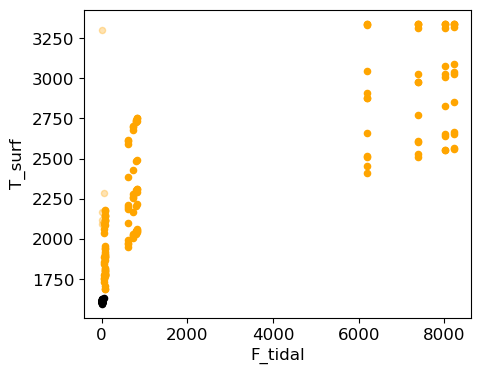

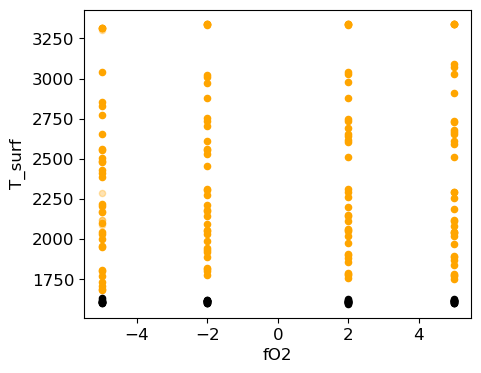

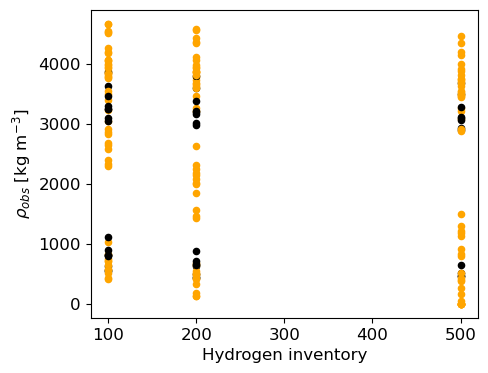

In [62]:
plt.close("all")

trend_any(
    "F_tidal", "F_tidal",
    "T_surf", "T_surf",
    control={},
    xscale="linear",
    yscale="linear",
    zscale="linear",
    histogram=False,
)

trend_any(
    "outgas.fO2_shift_IW", "fO2",
    "T_surf", "T_surf",
    control={},
    xscale="linear",
    yscale="linear",
    zscale="linear",
    histogram=False
)

trend_any(
    "delivery.elements.H_ppmw", "Hydrogen inventory",
    "rho_obs", r"$\rho_{obs}$ [kg m$^{-3}$]",
    control={},
    xscale="linear",
    yscale="linear",
    zscale="linear",
    histogram=False
)


## Variable1 vs P_surf,T_surf map

In [ ]:
def map_pt(z_key,z_lbl, control, logz=False):

    fig,ax = plt.subplots(figsize=(6,5))

    xs = []
    ys = []
    zs = []
    for i in range(ncases):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if not skip_this:
            xs.append(lg.access_hvars(hvars,"T_surf",-1)[i])
            ys.append(lg.access_hvars(hvars,"P_surf",-1)[i])
            zs.append(lg.access_hvars(hvars,z_key   ,-1)[i])
    mask = np.argsort(xs)
    xs = np.array(xs)[mask]
    ys = np.array(ys)[mask]
    zs = np.array(zs)[mask]

    if not logz:
        norm = mpl.colors.Normalize(vmin=np.amin(zs), vmax=np.amax(zs))
    else:
        norm = mpl.colors.LogNorm(vmin=np.amin(zs), vmax=np.amax(zs))
    cmap = sci_colormaps['batlow']
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    ax.scatter(xs,ys, c=zs, s=20, cmap=cmap, norm=norm)

    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    fig.colorbar(sm, cax=cax, orientation='vertical').set_label(z_lbl)

    ax.set_xlabel("Surface temperature [K]")
    ax.set_ylabel("Surface pressure [bar]")
    plt.show()

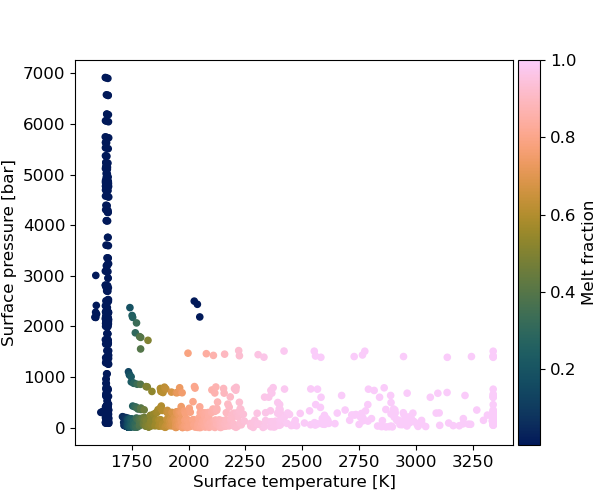

In [ ]:
control = {}

z_key = "Phi_global"
z_lbl = "Melt fraction"

map_pt(z_key,z_lbl, control, logz=False)

In [ ]:
def map_xyz(x_key,x_lbl,y_key,y_lbl,z_key,z_lbl, control, logx=False,logy=False,logz=False, ylim=(None,None), xscl=1.0, zscl=1.0):

    fig,ax = plt.subplots(figsize=(6,5))

    xs = []
    ys = []
    zs = []
    for i in range(ncases):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if not skip_this:
            xs.append(lg.access_hvars(hvars,x_key,-1)[i])
            ys.append(lg.access_hvars(hvars,y_key,-1)[i])
            zs.append(lg.access_hvars(hvars,z_key,-1)[i])
    mask = np.argsort(xs)
    xs = np.array(xs)[mask] * xscl
    ys = np.array(ys)[mask]
    zs = np.array(zs)[mask] * zscl

    if not logz:
        norm = mpl.colors.Normalize(vmin=np.amin(zs), vmax=np.amax(zs))
    else:
        norm = mpl.colors.LogNorm(vmin=np.amin(zs), vmax=np.amax(zs))
    # cmap = sci_colormaps['batlow']
    cmap = "jet"
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    ax.scatter(xs,ys, c=zs, s=20, cmap=cmap, norm=norm)

    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    fig.colorbar(sm, cax=cax, orientation='vertical').set_label(z_lbl)

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)

    if logx:
        ax.set_xscale("log")

    this_ylim = [np.amin(ys), np.amax(ys)]
    if logy:
        ax.set_yscale("log")
        this_ylim[0] /= 2
        this_ylim[1] *= 2
    else:
        this_ylim[0] /= 1.1
        this_ylim[1] *= 1.1

    if ylim[0] != None:
        this_ylim[0] = ylim[0]
    if ylim[1] != None:
        this_ylim[1] = ylim[1]
    ax.set_ylim(this_ylim)


    print("Data ymax = %g"%np.amax(ys))

    plt.show()

Data ymax = 259.359


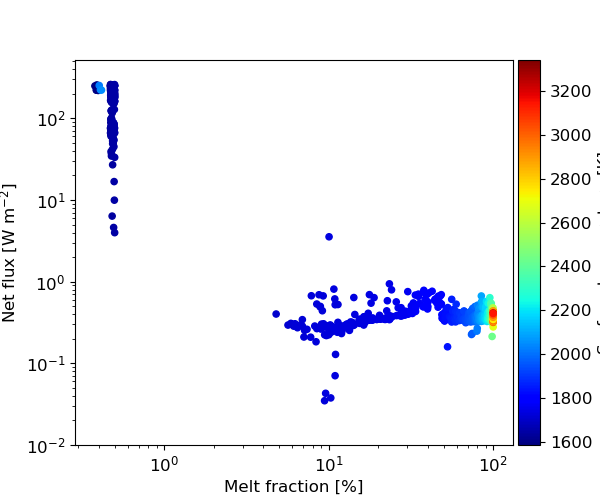

In [ ]:
z_key   = "T_surf"
z_lbl   = "Surface temperature [K]"
y_key   = "F_atm"
y_lbl   = "Net flux [W m$^{-2}$]"
x_key   = "Phi_global"
x_lbl   = "Melt fraction [%]"

control = {}

logx=True
logy=True
logz=False

ylim = (1e-2, None)

xscl = 100.0
zscl = 1

map_xyz(x_key,x_lbl,y_key,y_lbl,z_key,z_lbl, control, logx=logx,logy=logy,logz=logz, ylim=ylim, xscl=xscl, zscl=zscl)

Data ymax = 0.975647


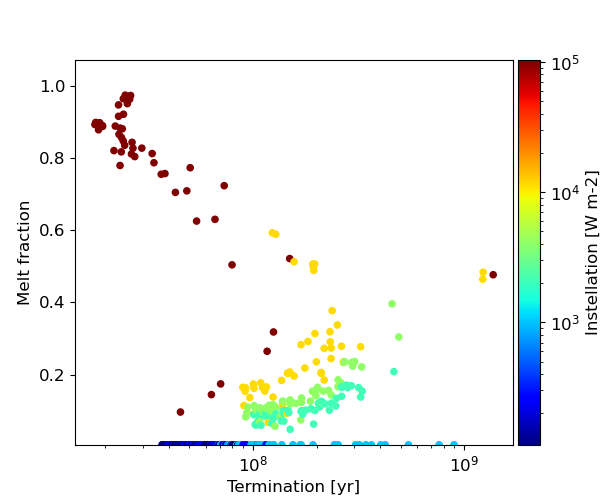

In [ ]:
z_key   = "F_ins"
z_lbl   = "Instellation [W m-2]"
y_key   = "Phi_global"
y_lbl   = "Melt fraction"
x_key   = "Time"
x_lbl   = "Termination [yr]"

control = {"hydrogen_earth_oceans":1.0}

logx=True
logy=False
logz=True

ylim = (None, None)

xscl = 100.0
zscl = 1

map_xyz(x_key,x_lbl,y_key,y_lbl,z_key,z_lbl, control, logx=logx,logy=logy,logz=logz, ylim=ylim, xscl=xscl, zscl=zscl)

In [ ]:
plt.close("all")

def histogram(logx=False,logy=False, relative=False):

    fig,ax = plt.subplots(1,1, figsize=(5,4))
    ax.set_xlabel("H2 VMR")

    xs_arr = []
    x_min = 1.0e-5
    x_max = 1.0
    phi_arr = np.arange(0.1, 0.8, 0.1)
    phi_arr = [round(v,1) for v in phi_arr]
    for phi in phi_arr:

        xs = []
        for i in range(ncases):
            if lg.access_hvars(hvars,"Phi_global",-1)[i] > phi:
                xs.append(lg.access_hvars(hvars,"H2_mr",-1)[i])

        x_min = min(x_min, np.amin(xs))
        x_max = max(x_max, np.amax(xs))
        xs_arr.append(xs)


    nbins = 20
    if logx:
        ax.set_xscale("log")
        bins = np.logspace(np.log10(x_min) , np.log10(x_max), nbins)
    else:
        bins = nbins

    if logy:
        ax.set_yscale("log")

    print(phi_arr)
    for i,p in enumerate(phi_arr):

        xs = xs_arr[i]
        hist,edges = np.histogram(xs, bins=bins)

        hist_x, hist_y = [],[]
        for i in range(len(hist)):

            hist_x.append(edges[i])
            hist_y.append(hist[i])

            hist_x.append(edges[i+1])
            hist_y.append(hist[i])

        hist_y = np.array(hist_y)
        ax.set_ylabel("Count")
        if relative:
            ax.set_ylabel("Fraction [%]")
            hist_y = 100.0*hist_y/np.amax(hist_y)
        hist_x = np.array(hist_x)

        ax.plot(hist_x, hist_y, label=p)

    ax.legend()
    plt.show()

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


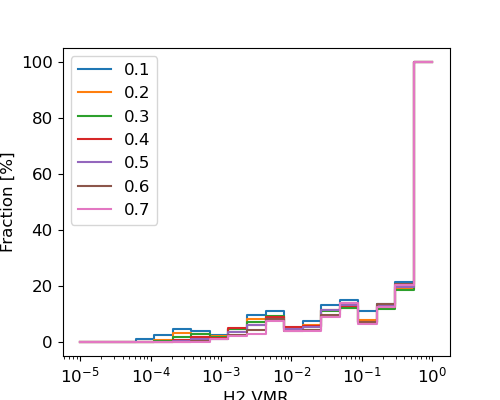

No such comm: 9462263fdecc4955bf617fbac4f61663


No such comm: cb2b88225a634b4d935e89e973ab181a


In [ ]:
logx=True
logy=False

histogram(logx=logx, logy=logy, relative=True)